In [61]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    StratifiedKFold,
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

# 1. Загрузка X и y и объединение в единый DataFrame

In [62]:
DATA_DIR = Path("../data")

X_PATH = DATA_DIR / "X.xlsx"
Y_PATH = DATA_DIR / "y.xlsx"

if not X_PATH.exists() or not Y_PATH.exists():
    raise FileNotFoundError("Файлы X.xlsx или y.xlsx не найдены")

In [63]:
X = pd.read_excel(X_PATH)

salary = pd.read_excel(Y_PATH).iloc[:, 0]
salary.name = "salary"

In [64]:
df = X.copy()
df["salary"] = salary.values

df.head()

,Пол,Возраст,position_group_analyst,position_group_dev,position_group_engineer,position_group_manager,position_group_marketing,position_group_other,position_group_support,city_medium_city,...,Авто_наличие,position_group_last_dev,position_group_last_engineer,position_group_last_manager,position_group_last_marketing_sales,position_group_last_other,position_group_last_support,position_group_last_sysadmin,edu_has_higher,salary
0,1,42,False,False,False,False,False,False,False,True,...,1,False,False,False,False,False,False,True,0,27000.0
1,1,41,False,False,False,False,False,False,False,False,...,0,False,True,False,False,False,False,False,1,60000.0
2,1,44,False,False,False,False,False,False,False,True,...,0,False,False,False,False,False,False,True,1,65000.0
3,1,43,False,True,False,False,False,False,False,False,...,0,False,False,False,False,True,False,False,1,70000.0
4,1,39,False,False,False,False,False,False,False,False,...,0,False,False,False,False,False,False,True,1,45000.0


# 2. Фильтрация IT-разработчиков

In [65]:
if "position_group_dev" not in df.columns:
    raise ValueError("Признак position_group_dev отсутствует в данных")

In [66]:
df_dev = df[df["position_group_dev"] == 1].copy()

# 3. Формируем целевую переменную level по опыту

In [67]:
if "years_experience" not in df_dev.columns:
    raise ValueError("Признак years_experience отсутствует в данных")

In [68]:
def experience_to_level(years: float) -> str:
    """Преобразует опыт работы в категорию уровня."""
    if years < 3:
        return "junior"
    if years < 6:
        return "middle"
    return "senior"

In [69]:
df_dev["level"] = df_dev["years_experience"].apply(experience_to_level)
df_dev.drop(columns=["years_experience"], inplace=True)

# 4. Анализ баланса классов

In [70]:
class_counts = (
    df_dev["level"]
    .value_counts()
    .reindex(["junior", "middle", "senior"])
)

In [71]:
plt.rcParams.update(
    {
        "font.family": "DejaVu Sans",
        "axes.titlesize": 16,
        "axes.titleweight": "bold",
        "axes.labelsize": 13,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
    }
)

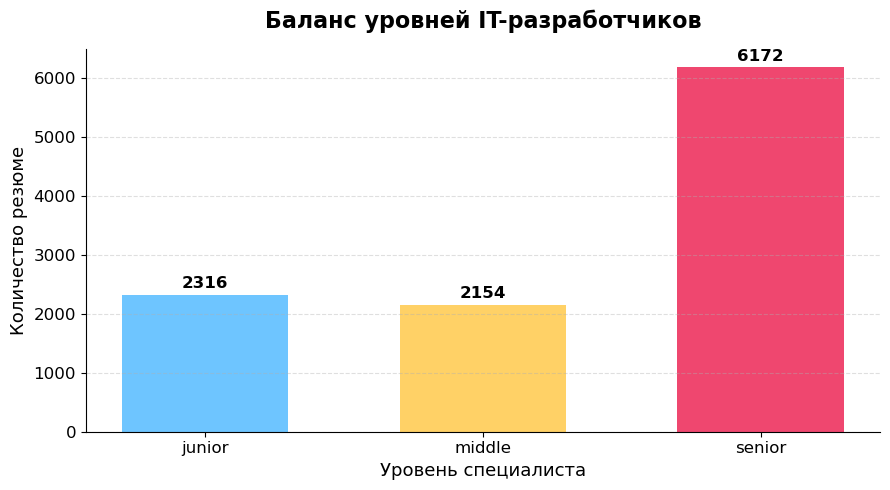

level
junior    2316
middle    2154
senior    6172
Name: count, dtype: int64

In [72]:
fig, ax = plt.subplots(figsize=(9, 5))

colors = ["#6EC5FF", "#FFD166", "#EF476F"]

bars = ax.bar(
    class_counts.index,
    class_counts.values,
    color=colors,
    width=0.6,
)

ax.set_title("Баланс уровней IT-разработчиков", pad=15)
ax.set_xlabel("Уровень специалиста")
ax.set_ylabel("Количество резюме")

ax.grid(axis="y", linestyle="--", alpha=0.4)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + class_counts.max() * 0.01,
        f"{int(height)}",
        ha="center",
        va="bottom",
        fontsize=12,
        fontweight="bold",
    )

plt.tight_layout()
plt.show()

class_counts

# 5. Подготовка данных к обучению

In [73]:
X = df_dev.drop(columns=["level"])
y = df_dev["level"]

In [74]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y,
)

# 6. Обучение модели с подбором гиперпараметров

In [75]:
pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        (
            "clf",
            LogisticRegression(
                multi_class="multinomial",
                solver="saga",
                max_iter=3000,
                class_weight="balanced",
                n_jobs=-1,
                random_state=42,
            ),
        ),
    ]
)

In [76]:
param_grid = {
    "clf__C": [0.01, 0.1, 1.0, 5.0, 10.0],
    "clf__penalty": ["l2", "l1", "elasticnet"],
    "clf__l1_ratio": [0.0, 0.5, 0.8],
}

In [77]:
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42,
)

In [78]:
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True,
)

In [79]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


C:\Users\User\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\Users\User\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,estimator,Pipeline(step...ver='saga'))])
,param_grid,"{'clf__C': [0.01, 0.1, ...], 'clf__l1_ratio': [0.0, 0.5, ...], 'clf__penalty': ['l2', 'l1', ...]}"
,scoring,'f1_macro'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


# 7. Лучшая модель и параметры

In [80]:
best_model = grid.best_estimator_

print("Best parameters:")
for param, value in grid.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest CV F1-macro: {grid.best_score_:.4f}")

Best parameters:
  clf__C: 0.1
  clf__l1_ratio: 0.0
  clf__penalty: l1

Best CV F1-macro: 0.6610


# 8. Оценка качества модели

In [81]:
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

In [82]:
print("=== TRAIN SET ===")
print(classification_report(y_train, y_train_pred))

print("=== TEST SET ===")
print(classification_report(y_test, y_test_pred))

=== TRAIN SET ===
              precision    recall  f1-score   support

      junior       0.66      0.74      0.70      1737
      middle       0.40      0.55      0.46      1615
      senior       0.92      0.76      0.83      4629

    accuracy                           0.71      7981
   macro avg       0.66      0.68      0.67      7981
weighted avg       0.76      0.71      0.73      7981

=== TEST SET ===
              precision    recall  f1-score   support

      junior       0.70      0.75      0.72       579
      middle       0.41      0.56      0.47       539
      senior       0.91      0.77      0.83      1543

    accuracy                           0.72      2661
   macro avg       0.67      0.69      0.68      2661
weighted avg       0.76      0.72      0.74      2661



# 9. Анализ важности признаков

In [83]:
clf = best_model.named_steps["clf"]

feature_names = X.columns
classes = clf.classes_
coef = clf.coef_

In [84]:
importance = pd.DataFrame(
    coef.T,
    index=feature_names,
    columns=classes,
)

In [85]:
importance_compare = (
    importance[classes]
    .abs()
    .sort_values("senior", ascending=False)
    .head(20)
)

importance_compare

,junior,middle,senior
Возраст,1.717247,0.000000,2.257338
salary,0.743298,0.000000,0.463186
position_group_last_manager,0.000000,0.000000,0.148886
Авто_наличие,0.103569,0.000000,0.147419
position_group_last_other,0.020472,0.000000,0.121100
city_moscow,0.122632,0.000000,0.110791
part_time,0.000000,0.000000,0.105040
position_group_last_sysadmin,0.000000,0.009543,0.103980
business_trip_yes,0.149880,0.000000,0.096346
edu_has_higher,0.001461,0.000000,0.091980


## Выводы

# Баланс классов:

junior — 2 316, middle — 2 154, senior — 6 172

Класс middle размытый и сложный для классификации.

# Качество модели:

CV F1-macro ≈ 0.66, Test F1-macro ≈ 0.68, accuracy ≈ 0.72

Метрики TRAIN ≈ TEST → модель не переобучается

# Анализ ошибок:

Senior: высокая точность, немного пропусков

Junior: средняя точность/recall

Middle: самая сложная категория → низкая precision, средний recall

# Важные признаки:

Возраст, зарплата, предыдущая должность, город, образование

Признаки логично отражают рынок труда

# Вывод:

Подход жизнеспособен: по hh.ru можно отличать junior/middle/senior с разумным качеством

Основные ограничения: дисбаланс, размытая разметка middle, ограниченные признаки